In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
import preprocess, sweep_utils
from plotting_utils import figSize, setTickLabels
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *
from click_utils import *


pearson_r_thresh = 0.15**0.5
#pearson_r_thresh = None 


method_list  = ['HMM', 
                'Stabilizer', 
                'HMM-Stabilizer',
                'ADAN']

params_list  = [['kappa', 'inflection', 'exp'],
               ['B', 'n_components', 'thresh'],
               ['kappa', 'inflection', 'exp'],
               ['d_lr', 'g_lr', 'n_epochs']]

prune_list   = [None, 
                {'model' : 'FactorAnalysis'}, 
                None, 
                None] 


method_list  = ['ADAN']
params_list  = [['d_lr', 'g_lr', 'batch_size']]
prune_list   = [None] 


scores_df_list = list()
for fignum, (method, params) in enumerate(zip(method_list, params_list)):
    
    SWEEP_DIR = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/T5/{}/*sweep/'.format(method)

    # load files and check if any are missing:
    files    = glob.glob(SWEEP_DIR + '*scores_ID*')

    file_IDs = [int(x.split('ID_')[1].split('.npy')[0]) for x in files]
    maxval   = np.max(file_IDs)
    diff     = np.setdiff1d(np.arange(maxval + 1), file_IDs)

    if len(diff) > 0:
        raise ValueError('Missing sweeps: ', diff)

    scores_df  = sweep_utils.getSummaryDataFrame(files, params + ['days_apart', 'file', 'R2_score', 'pearson_r', 'meanrecal_pearson_r'], #'meanrecal_pearson_r', 'pearson_r', 'days_apart', 'file'], 
                                                prune = prune_list[fignum], int_encode_files = True)
    if pearson_r_thresh is not None:
        scores_df_list.append(scores_df[scores_df['meanrecal_pearson_r'] > pearson_r_thresh])
    else:
        scores_df_list.append(scores_df)

    del scores_df
    print('Done loading', method)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done loading ADAN


Now plot loaded data:

{'d_lr': 5e-06, 'g_lr': 5e-06, 'batch_size': 16} pearson_r= 0.6329898279697292


/tmp/ipykernel_29946/1877421195.py:54: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = metric, palette = palette, alpha = 0.6)
/tmp/ipykernel_29946/1877421195.py:54: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = metric, palette = palette, alpha = 0.6)
/tmp/ipykernel_29946/1877421195.py:54: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = metric, palette = palette, alpha = 0.6)


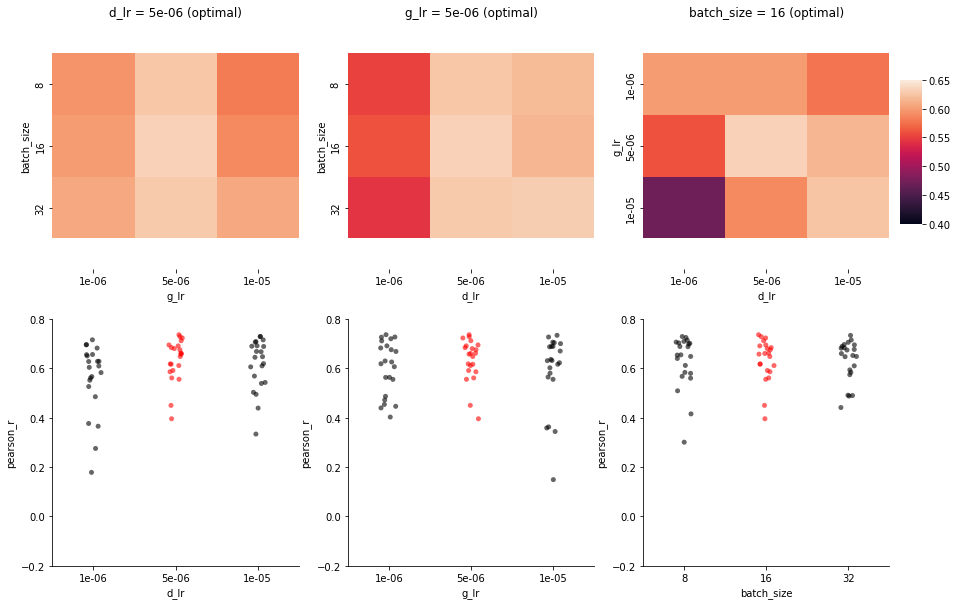

In [5]:
metric       = 'pearson_r'
heatmap_clim = [0.4, 0.65]
scatter_clim = [-0.2, 0.8]
fig_path     = '/home/users/ghwilson/projects/nonstationarities/figures/'


for fignum, (method, params) in enumerate(zip(method_list, params_list)):
    scores_df = scores_df_list[fignum]

    # infer parameter sweeps
    sweep_opts = dict()
    for param in params:
        sweep_opts[param] = np.unique(scores_df[param])

    # get optimal parameter values (argmax median score)
    scores_mat_df = scores_df.groupby(params)[metric].mean()
    opt_dict = dict()
    for i, key in enumerate(scores_mat_df.index.names):
        opt_dict[key] = scores_mat_df.idxmax()[i]
    print(opt_dict, f'{metric}=', scores_mat_df.max())
    
    figSize(10, 15)
    fig = plt.figure(fignum)
    cbar_ax = fig.add_axes([.91, .6, .02, .2])

    for i, var in enumerate(opt_dict.keys()):

        var_opt  = opt_dict[var]
        opt_idx  = np.where(sweep_opts[var] == var_opt)[0][0]

        opt_copy = dict(opt_dict)
        opt_copy.pop(var)
        
        # Heatmap plots
        plt.subplot(2, 3, i + 1)
        in_df = scores_df[scores_df[var] == var_opt]
        df_m  = in_df.groupby([list(opt_copy.keys())[0], list(opt_copy.keys())[1]])[metric].mean().unstack(level = 0)
        sns.heatmap(df_m, vmin = heatmap_clim[0], vmax = heatmap_clim[1], annot = False,
                    cbar = i == 0, cbar_ax = None if i else cbar_ax)
        plt.title('{} = {} (optimal)'.format(var, var_opt))

        # fix matplotlib 3.1.1 issue
        ax = plt.gca()
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)

        # Strip plots
        plt.subplot(2, 3, i + 3 + 1)
        scores_subset = sweep_utils.get_subsetDF(scores_df, opt_copy)

        palette          = ['k'] * len(sweep_opts[var])
        palette[opt_idx] = 'r'
        #scores_subset[metric] -= scores_subset['meanrecal_pearson_r']
        sns.stripplot(data = scores_subset, x = var, y = metric, palette = palette, alpha = 0.6)

        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        plt.legend([], [], frameon = False)
        plt.ylim(scatter_clim)
    
    plt.savefig(fig_path + f'comparisons/train_hyperparams_{method}', format = 'pdf')
    plt.show()
    #del scores_df, in_df, scores_mat_df

In [9]:
DATA_DIR     = f'/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/session_pairs/'
files        = glob.glob(DATA_DIR + '*')

In [10]:
len(files)

2628

In [12]:
2628 / 1350

1.9466666666666668